
## **Pix2Pix Implementation**



*   Given input to disc are - (real, fake) img pairs from gen, original.

*   Gen - Unet bcz - has skip connections - captures low level features, less blurry.  

*   In our case,gen generates RGB from NIR as input; this (RGB, NIR) pair along with original (RGB, NIR) pairs are given as inputs to disc; which then tries to identify the real and fake pairs.

*   Disc - N x N Patch GAN - tries to classify if each patch is real/fake -- rather than whole image. Sharp results

*   Gen - L1 MAE loss + GAN loss (100:1)

*   Disc - classification loss like sigmoid real/fake pair

[Blog on Pix2Pix Gans](https://neptune.ai/blog/pix2pix-key-model-architecture-decisions#What-Is-the-Pix2Pix-GAN?)








---
**Funny Applications**

*   [Image to Image Demo](https://affinelayer.com/pixsrv/)
*   [AI Draw](https://ai-draw.tokyo/en/)
---


SIMPLE GAN ARCHITECTURE

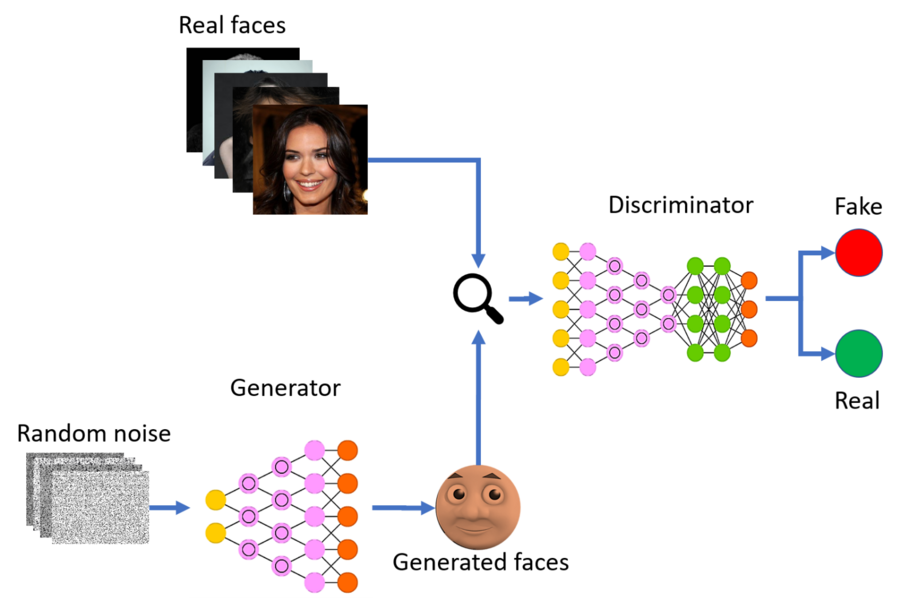

**Pix2Pix**

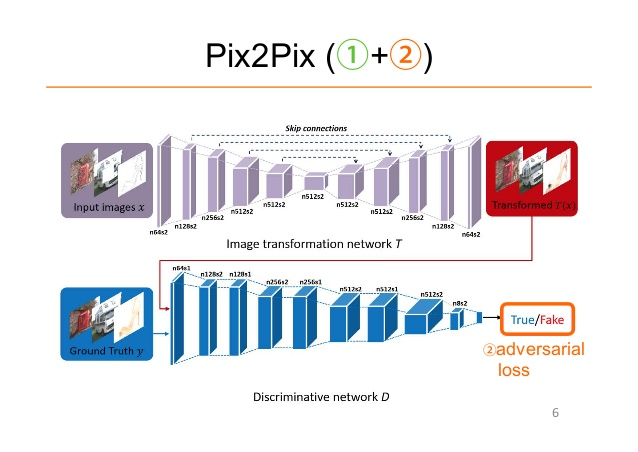

**PATCH GAN**  [blog link](https://blog.paperspace.com/unpaired-image-to-image-translation-with-cyclegan/)

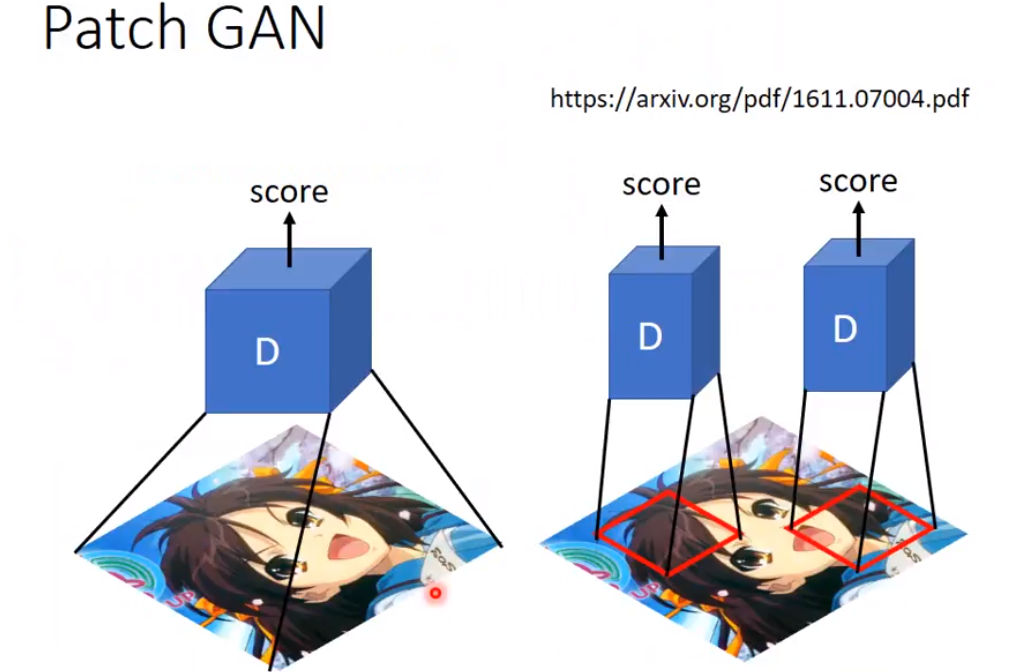

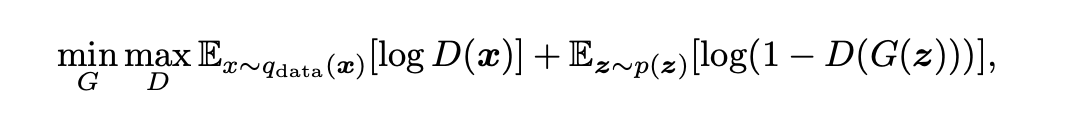

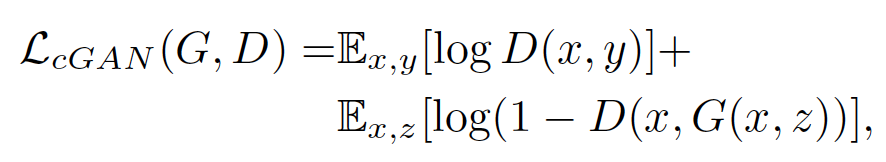

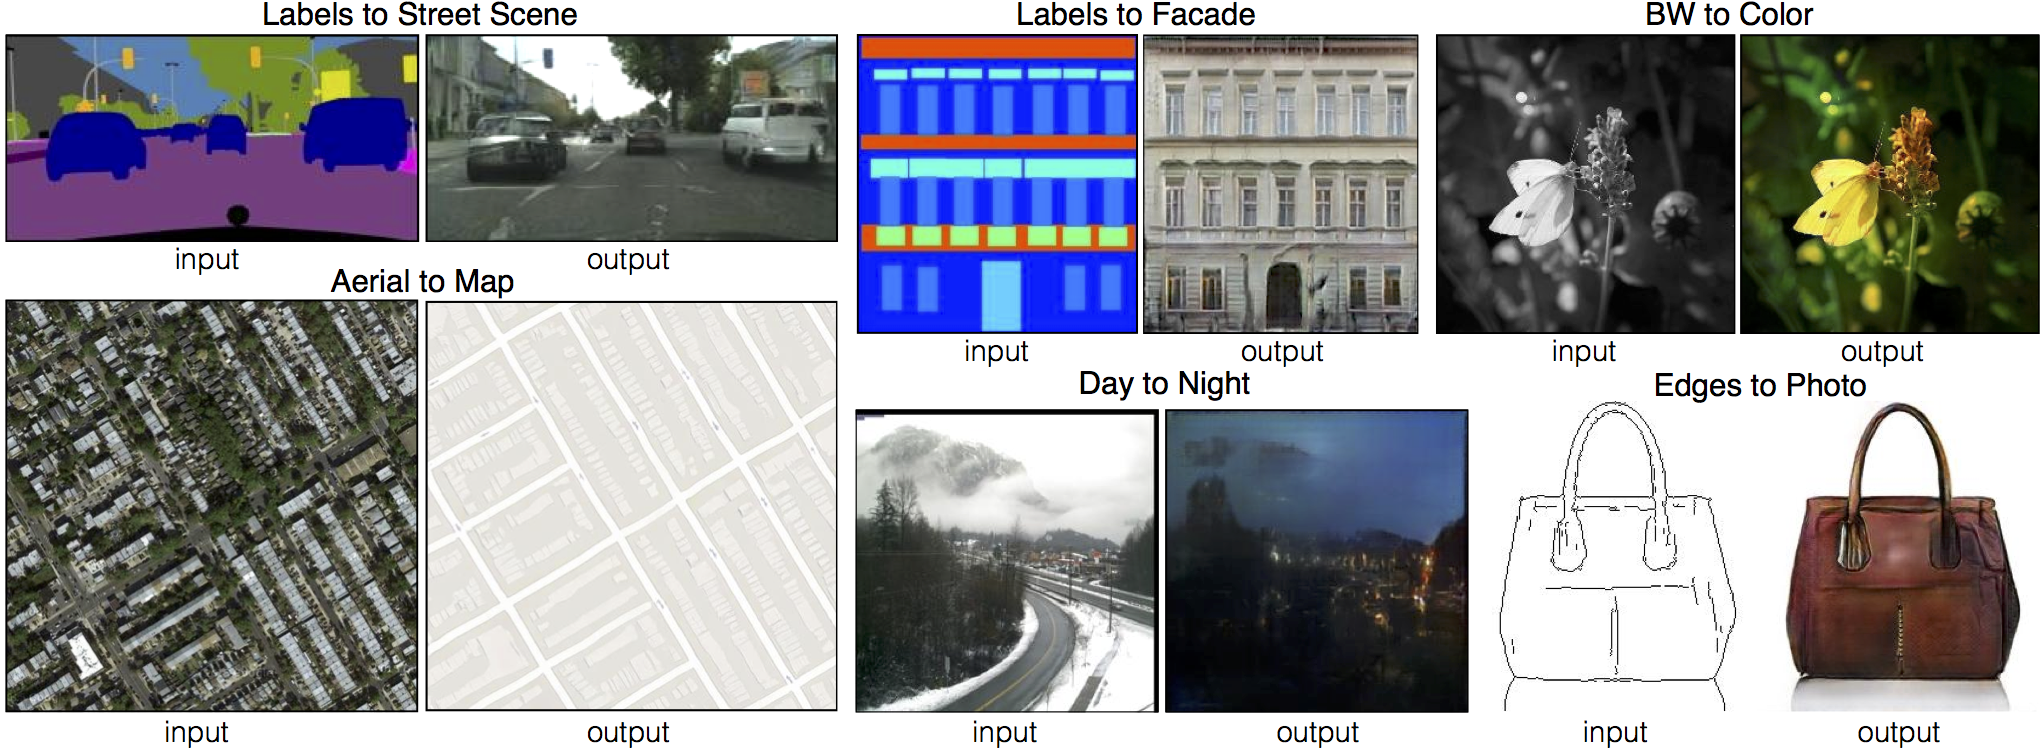

# PATHS

In [ ]:
import os

rgb_dir = r"E:\day-1-dataset\rgb"
nir_dir = r"E:\day-1-dataset\nir"

rgb_train = os.path.join(rgb_dir, "train")
nir_train = os.path.join(nir_dir, "train")

rgb_val = os.path.join(rgb_dir, "val")
nir_val = os.path.join(nir_dir, "val")

rgb_test = os.path.join(rgb_dir, "test")
nir_test = os.path.join(nir_dir, "test")

# SAMPLE MODEL

## IMPORTS

In [ ]:
import os
import time


import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
from imageio import imread

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets, models

import torchmetrics
from torchmetrics import JaccardIndex

from tqdm import tqdm
from torchsummary import summary

import pytorch_lightning as pl

import segmentation_models_pytorch as smp

# https://pytorch-lightning.readthedocs.io/en/stable/common/progress_bar.html
from pytorch_lightning.callbacks import RichProgressBar

from pytorch_lightning.loggers import WandbLogger

import wandb

import warnings
warnings.filterwarnings("ignore")

## DATA DATALOADER

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 4
NUM_WORKERS = 0
CHANNELS_IMG = 3
image_size = 512


both_transform = A.Compose(
    [A.Resize(width=image_size, height=image_size),], additional_targets={"image0": "image"},
)

transform_only_nir = A.Compose(
    [
        A.Resize(width=image_size, height=image_size),
        A.Normalize(mean=[0.4076, 0.4076, 0.4076], std=[0.2862, 0.2862, 0.2862], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_rgb = A.Compose(
    [
        A.Resize(width=image_size, height=image_size),
        A.Normalize(mean=[0.7316, 0.6996, 0.7033], std=[0.3512, 0.3566, 0.3559], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [ ]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image


class MapDataset(Dataset):
    def __init__(self, rgb_dir, nir_dir):
        self.rgb_dir = rgb_dir
        self.nir_dir = nir_dir
        self.list_files = os.listdir(self.rgb_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        nir_img_path = os.path.join(self.nir_dir, img_file)
        rgb_img_path = os.path.join(self.rgb_dir, img_file)
        
        nir_image = np.array(Image.open(nir_img_path))  
        rgb_image = np.array(Image.open(rgb_img_path))

        augmentations = both_transform(image=nir_image, image0=rgb_image)
        nir_image = augmentations["image"]
        rgb_image = augmentations["image0"]

        nir_image = transform_only_nir(image=nir_image)["image"]
        rgb_image = transform_only_rgb(image=rgb_image)["image"]

        return rgb_image, nir_image

In [ ]:
class DataModuleNIR2RGB(pl.LightningDataModule):
  def __init__(self):
    super().__init__()
    self.batch_size = BATCH_SIZE
  
  def prepare_data(self):
    # Downloading our data, etc
    pass
  
  def setup(self, stage=None):
    # Loading our data after applying the transforms
    self.train_ds = MapDataset(rgb_train, nir_train)
    
    self.val_ds = MapDataset(rgb_val, nir_val)
    
  def train_dataloader(self):
    return DataLoader(self.train_ds, batch_size=self.batch_size,
                      num_workers=0, pin_memory=True,
                      shuffle=True)
  
  def val_dataloader(self):
    return DataLoader(self.val_ds, batch_size=self.batch_size,
                      num_workers=0, pin_memory=True,
                      shuffle=True)
  
  def test_dataloader(self):
    return DataLoader(self.val_ds, batch_size=self.batch_size,
                      num_workers=0, pin_memory=True,
                      shuffle=True)

In [ ]:
data_ = DataModuleNIR2RGB()

## Calculate Mean, Std

In [ ]:
##### COMPUTE PIXEL SUM AND SQUARED SUM

# placeholders
rpsum    = torch.tensor([0.0])
rpsum_sq = torch.tensor([0.0])

npsum    = torch.tensor([0.0])
npsum_sq = torch.tensor([0.0])

# loop through images
for rgb_path in os.listdir(rgb_train):
  path = os.path.join(r"E:\day-1-dataset\rgb\train", rgb_path)
  rgb = np.asarray(Image.open(path)).astype('float32')
  rgb /= 255.0
  rpsum    += rgb.sum(axis        = (0, 1))
  rpsum_sq += (rgb ** 2).sum(axis = (0, 1))

for nir_path in os.listdir(nir_train):
  path = os.path.join(r"E:\day-1-dataset\nir\train", nir_path)
  nir = np.asarray(Image.open(path)).astype('float32')
  nir /= 255.0
  npsum    += nir.sum(axis        =(0, 1))
  npsum_sq += (nir ** 2).sum(axis = (0, 1))

In [ ]:
####### FINAL CALCULATIONS

# pixel count
count = tot_imgs * 1536 * 2048

# RGB mean and std
rtotal_mean = rpsum / count
rtotal_var  = (rpsum_sq / count) - (rtotal_mean ** 2)
rtotal_std  = torch.sqrt(rtotal_var)

# NIR mean and std
ntotal_mean = npsum / count
ntotal_var  = (npsum_sq / count) - (ntotal_mean ** 2)
ntotal_std  = torch.sqrt(ntotal_var)

# output
print('RGB mean: '  + str(rtotal_mean))
print('RGB std:  '  + str(rtotal_std))

# output
print('NIR mean: '  + str(ntotal_mean))
print('NIR std:  '  + str(ntotal_std))

RGB mean: tensor([0.7316, 0.6996, 0.7033])
RGB std:  tensor([0.3512, 0.3566, 0.3559])
NIR mean: tensor([0.4076, 0.4076, 0.4076])
NIR std:  tensor([0.2862, 0.2862, 0.2862])


## DISPLAY IMG PAIR

In [ ]:
train_ds = MapDataset(rgb_train, nir_train)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                      num_workers=0, pin_memory=True,
                      shuffle=True)

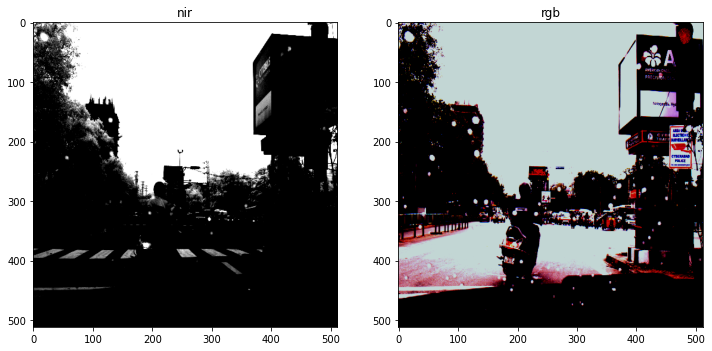

In [ ]:
rgb, nir = next(iter(train_loader))

nir = np.clip(nir[2].detach().cpu().permute(1, 2, 0).numpy(), 0, 1)
rgb = np.clip(rgb[2].detach().cpu().permute(1, 2, 0).numpy(), 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(nir)
ax[1].imshow(rgb)
ax[0].set_title("nir")
ax[1].set_title("rgb")
plt.show()

## MODEL

In [ ]:
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
def display_progress(nir, rgb, generated, figsize=(12, 12)):
    nir = np.clip(nir.detach().cpu().permute(1, 2, 0).numpy(), 0, 1)
    rgb = np.clip(rgb.detach().cpu().permute(1, 2, 0).numpy(), 0, 1)
    generated = np.clip(generated.detach().cpu().permute(1, 2, 0).numpy(), 0, 1)
    
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(nir)
    ax[1].imshow(rgb)
    ax[2].imshow(generated)

    ax[0].set_title("nir")
    ax[1].set_title("rgb")
    ax[2].set_title("generated")
    plt.show()

In [ ]:
import torch
from torch import nn


class UpSampleConv(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True, dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x


class DownSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        """Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)


class PatchGAN(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

In [ ]:
import torch
from pytorch_lightning import LightningModule
from torch import nn

class Pix2Pix(pl.LightningModule):

    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=200):

        super().__init__()
        self.save_hyperparameters()
        
        self.gen = Generator(in_channels, out_channels)
        self.patch_gan = PatchGAN(in_channels + out_channels)

        # intializing weights
        self.gen = self.gen.apply(_weights_init)
        self.patch_gan = self.patch_gan.apply(_weights_init)

        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()

    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # First calculate the adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.patch_gan(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # calculate reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)
        lambda_recon = self.hparams.lambda_recon

        return adversarial_loss + lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.patch_gan(fake_images, conditioned_images)

        real_logits = self.patch_gan(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        gen_opt = torch.optim.Adam(self.gen.parameters(), lr=lr)
        disc_opt = torch.optim.Adam(self.patch_gan.parameters(), lr=lr)
        return disc_opt, gen_opt

    def training_step(self, batch, batch_idx, optimizer_idx):
        rgb, nir = batch

        loss = None
        if optimizer_idx == 0:
            loss = self._disc_step(rgb, nir)
            self.log("disc loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        elif optimizer_idx == 1:
            loss = self._gen_step(rgb, nir)
            self.log("gen loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        if optimizer_idx==1 and batch_idx % 40 == 0:
            generated = self.gen(nir).detach()
            print("Displaying Train Images")
            display_progress(nir[0], rgb[0], generated[0])

        return loss
      
    def validation_step(self, batch, batch_idx):
        rgb, nir = batch

        loss = None
        loss = self._gen_step(rgb, nir)
        
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        generated = self.gen(nir).detach()

        if batch_idx % 15 == 0:
            print("Displaying Val Images")
            display_progress(nir[0], rgb[0], generated[0])

        return loss
    
    def validation_step(self, batch, batch_idx):
        rgb, nir = batch

        loss = None
        loss = self._gen_step(rgb, nir)
        
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        generated = self.gen(nir).detach()

        if batch_idx % 15 == 0:
            print("Displaying Val Images")
            display_progress(nir[0], rgb[0], generated[0])

        return loss

    def test_step(self, batch, batch_idx):
        rgb, nir = batch

        loss = None
        loss = self._gen_step(rgb, nir)
        
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        generated = self.gen(nir).detach()

        if batch_idx % 15 == 0:
            print("Displaying Test Images")
            display_progress(nir[0], rgb[0], generated[0])

        return loss

In [ ]:
# These configurations are from paper

adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200
n_epochs = 20
batch_size = 4
lr = 0.0002
target_size = 512
device = 'cuda'

In [ ]:
# https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing.html

checkpoints_path = r"E:\Code-pix2pix\save\checkpoints"

pix2pix = Pix2Pix(3, 3, learning_rate=0.002, lambda_recon=lambda_recon)

wandb_logger = WandbLogger(project="pix2pix")

trainer = pl.Trainer(default_root_dir=checkpoints_path,
                     logger = wandb_logger,
                     max_epochs=30,
                     gpus=1,
                     callbacks=[RichProgressBar(leave=True)]
                     )
trainer.fit(pix2pix, data_)